# CNN and QCNN tests on MNIST handwritten digits dataset

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime
import os

from tensorflow.keras.datasets import mnist
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [32]:
colors = [
    "#7eb0d5",
    "#fd7f6f",
    "#b2e061",
    "#bd7ebe",
    "#ffb55a",
    "#8bd3c7"
]

## Quick data exploration

In [2]:
# load dataset
(trainX, trainY), (testX, testY) = mnist.load_data()

In [3]:
print(f"Training set shape:\t{trainX.shape}")
print(f"Training labels shape:\t{trainY.shape}")
print(f"Test set shape:\t\t{testX.shape}")
print(f"Test labels shape:\t{testY.shape}")

Training set shape:	(60000, 28, 28)
Training labels shape:	(60000,)
Test set shape:		(10000, 28, 28)
Test labels shape:	(10000,)


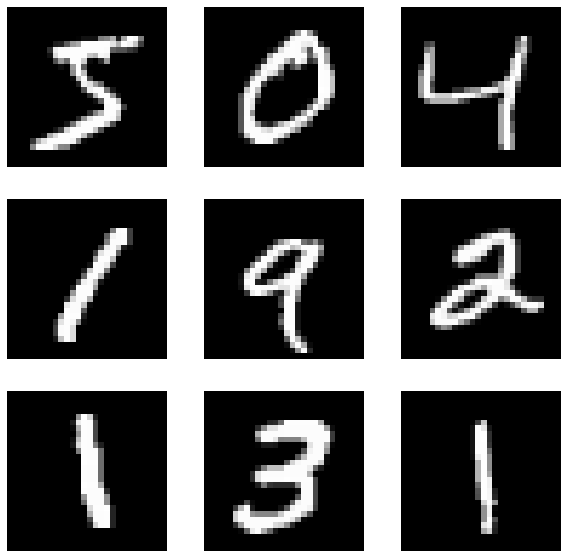

In [4]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    ax = fig.add_subplot(330 + 1 + i)
    ax.axis("off")
    ax.imshow(trainX[i], cmap="gray")
    
plt.show()

## Data preprocessing for CNN

1. we need to change the shape of data to fit the CNN requirements, i.e. we need to add the number of channels as last dimension
2. we need to hot-encode the label set

In [5]:
# grey-scale ==> 1 channel
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2], 1)
testX  = testX.reshape(testX.shape[0], testX.shape[1], testX.shape[2], 1)

# pixel normalization
trainX = trainX.astype("float32")
testX  = testX.astype("float32")
trainX = trainX / 255
testX  = testX / 255

# label one-hot encoding
trainY = tf.keras.utils.to_categorical(trainY)
testY  = tf.keras.utils.to_categorical(testY)

## CNN model

In [6]:
class CNN(tf.keras.Model):
    def __init__(
        self,
        input_dim, # n_samples, image size and channels
        n_classes, # dimension of one-hot encoded labels
        conv_activation    = "relu",
        hidden_activation  = "relu",
        cnn_name           = "my convo neural network",
        **kwargs
    ):
        
        # initialize parent class
        super().__init__(**kwargs)

        # store the model name
        self.cnn_name = cnn_name

        self.input_layer = tf.keras.layers.Input(shape=input_dim[1:], name="input")
        
        self.conv_1  = tf.keras.layers.Conv2D(32, (3, 3), activation=conv_activation, input_shape=input_dim[1:], name="conv_1")
        self.pool_1  = tf.keras.layers.MaxPooling2D((2, 2), name="pool_1")
        self.conv_2  = tf.keras.layers.Conv2D(64, (3, 3), activation=conv_activation, name="conv_2")
        self.conv_3  = tf.keras.layers.Conv2D(64, (3, 3), activation=conv_activation, name="conv_3")
        self.pool_2  = tf.keras.layers.MaxPooling2D((2, 2), name="pool_2")
        self.flatten = tf.keras.layers.Flatten(name="flatten")
        self.dense_1 = tf.keras.layers.Dense(100, activation=hidden_activation, name="dense_1")
        self.out     = tf.keras.layers.Dense(n_classes, activation="softmax", name="output")
        
        self.build(input_shape=input_dim)

        

    def call(self, inputs):
        """the call method deals with model creation"""

        x = self.conv_1(inputs)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.pool_2(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        
        return self.out(x)
    
    def summary(self):
        """re-define summary method to fix the output_shape : multiple issue"""

        # create a temporary model with all the computed shapes (thanks to self.call method)
        model = tf.keras.Model(
            inputs  = [self.input_layer], 
            outputs = self.call(self.input_layer),
            name    = self.cnn_name
        )

        # return the model summary with computed shapes
        return model.summary(line_length=100)

In [13]:
input_dim = trainX.shape
n_classes = trainY.shape[-1]

model = CNN(
    input_dim=input_dim,
    n_classes=n_classes,
)

optimizer     = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
loss_function = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss_function, metrics=["accuracy"])

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.summary()

Model: "my convo neural network"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input (InputLayer)                          [(None, 28, 28, 1)]                     0              
                                                                                                    
 conv_1 (Conv2D)                             (None, 26, 26, 32)                      320            
                                                                                                    
 pool_1 (MaxPooling2D)                       (None, 13, 13, 32)                      0              
                                                                                                    
 conv_2 (Conv2D)                             (None, 11, 11, 64)                      18496          
                                                          

## Training the model and evaluating its performance

In [14]:
BATCH_SIZE = 32
EPOCHS     = 30

history = model.fit(
    trainX, 
    trainY, 
    batch_size      = BATCH_SIZE,
    epochs          = EPOCHS, 
    validation_data = (testX, testY),
    verbose         = 0,
    callbacks       = [tensorboard_callback]
)

loss, acc = model.evaluate(testX, testY, verbose=0)

2022-05-05 09:40:01.642198: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-05 09:40:01.814154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-05 09:40:15.942005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [124]:
model_number = 2

dir_name = f"models/lai_model_{model_number}"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    model.save(dir_name, save_format="tf")
    
# model = tf.keras.models.load_model("models/lai_model_1/")

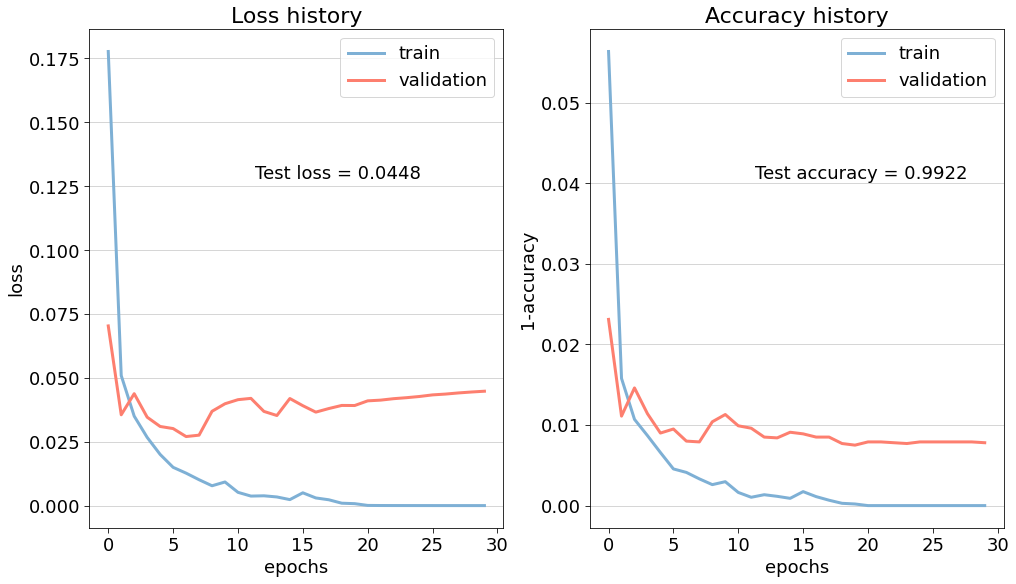

In [78]:
FONTSIZE = 18

train_loss_history = np.array(history.history["loss"])
train_acc_history  = np.array(history.history["accuracy"])

valid_loss_history = np.array(history.history["val_loss"])
valid_acc_history  = np.array(history.history["val_accuracy"])

epochs_grid = np.arange(0, EPOCHS, 1)

fig, (ax1, ax2) = plt.subplots(figsize=(14, 8), ncols=2, sharex=True, constrained_layout=True)

ax1.set_axisbelow(True)
ax1.grid(axis="y", color="black", alpha=0.2)
ax2.set_axisbelow(True)
ax2.grid(axis="y", color="black", alpha=0.2)

ax1.set_title("Loss history",     fontsize=FONTSIZE+4)
ax1.set_xlabel("epochs",          fontsize=FONTSIZE)
ax1.set_ylabel("loss",            fontsize=FONTSIZE)
ax1.tick_params(axis="both", which="major", labelsize=FONTSIZE, length=5)
ax2.set_title("Accuracy history", fontsize=FONTSIZE+4)
ax2.set_xlabel("epochs",          fontsize=FONTSIZE)
ax2.set_ylabel("1-accuracy",      fontsize=FONTSIZE)
ax2.tick_params(axis="both", which="major", labelsize=FONTSIZE, length=5)

ax1.plot(epochs_grid, train_loss_history,  linewidth=3, color=colors[0], label="train")
ax1.plot(epochs_grid, valid_loss_history,  linewidth=3, color=colors[1], label="validation")
ax2.plot(epochs_grid, 1-train_acc_history, linewidth=3, color=colors[0], label="train")
ax2.plot(epochs_grid, 1-valid_acc_history, linewidth=3, color=colors[1], label="validation")

ax1.text(0.4, 0.7, f"Test loss = {loss:.4f}",    fontsize=FONTSIZE, transform=ax1.transAxes)
ax2.text(0.4, 0.7, f"Test accuracy = {acc:.4f}", fontsize=FONTSIZE, transform=ax2.transAxes)

ax1.set_yscale("linear")
ax2.set_yscale("linear")

ax1.legend(fontsize=FONTSIZE)
ax2.legend(fontsize=FONTSIZE)

plt.show()

## Make predictions on data

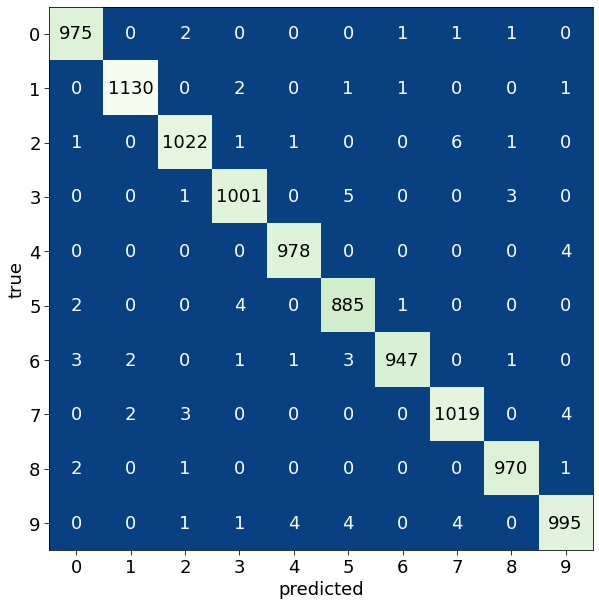

In [122]:
import itertools

labels = np.arange(0, 10, 1)
pred_lab = np.argmax(model.predict(testX), axis=1)
true_lab = np.argmax(testY, axis=1)

cm = confusion_matrix(true_lab, pred_lab)

fig, ax = plt.subplots(figsize=(10, 10))

mat = ax.matshow(cm, cmap="GnBu_r")

threshold = mat.norm(cm.max())/2.
textcolors = ["white", "black"]
for i, j in itertools.product(range(len(labels)), range(len(labels))):
    text = ax.text(
        j, 
        i, 
        f"{cm[i, j]}",#*100:.1f}%", 
        ha       = "center", 
        va       = "center", 
        color    = textcolors[int(mat.norm(cm[i, j]) > threshold)],
        fontsize = FONTSIZE
    )
    
ax.set_xlabel("predicted", fontsize=FONTSIZE)
ax.set_ylabel("true",      fontsize=FONTSIZE)

ax.xaxis.set_ticks_position("bottom")
ax.tick_params(axis="both", which="major", labelsize=FONTSIZE, length=5)
ax.set_xticks(labels)
ax.set_yticks(labels)
    
plt.show()